# Handwritten Digits Classification

### Sidclay da Silva

### June 2022

---

### Introduction

In this notebook we develop a Python model for image classification of handwritten digits using a convolutional neural network (CNN) based on TensorFlow framework.

Explanation of concepts and logic is provided to help understanding the steps along the notebook, but there is no detailed explanation about the code, some Phyton and arrays knowledge is required to follow it.

The environment uses Python 3.7, TensorFlow 2.8 and TensorFlow Datasets 4.0.

---

### MNIST Database

The images used in this project are from the well known MNIST Database, a collection 70,000 handwritten digit images. For details please check the original work of Yann LeCun, Corinna Cortes and Christopher Burges at http://yann.lecun.com/exdb/mnist/.

The images database is available in several formats and sources on the internet, TensorFlow already provides it as dataset, details at https://www.tensorflow.org/datasets/catalog/mnist.

Our source will be the Extendet MNIST (EMNIST) Python package (https://pypi.org/project/emnist/) from Aaron Hosford. It provides the image database as Numpy array, this gives us a good opportunity to see how to prepare arrays to be used as input tensors in TensorFlow, a usefull knowledge to be replicated in future projects when dealing with our own data.

The first thing to do is to have EMNIST package installed.

In [ ]:
# install emnist package
! pip install emnist

Next we import the required libraries, and from EMNIST we import functions extract_training_samples() and extract_test_samples(), as their names suggest, they are used to extract the training and test sample data.

In [1]:
# import packages
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from emnist import extract_training_samples, extract_test_samples

# set Numpy precision for printing
np.set_printoptions(precision=3)

### Loading Data

The EMNIST package contains the complete EMNIST Database, which includes different subsets of handwritten digits and letters, for details please check The EMNIST Dataset official webpage at https://www.nist.gov/itl/products-and-services/emnist-dataset.

To extract the desired subset samples, we use the respective function, training or test, having the subset name as parameter, e.g. for MNIST training subset use extract_training_samples('mnist').

The EMNIST/MNIST subset contains a collection of 60,000 training and 10,000 test images with shape (28,28) in grayscale format, all of them with their respective labels. When extracted the data is loaded into two Numpy arrays, one receives images data and the other labels data. The images are labeled with one out of ten different classes, from 0 to 9.

In [2]:
# load training and test data from emnist/mnist
img_train, lbl_train = extract_training_samples('mnist')
img_test, lbl_test = extract_test_samples('mnist')

# print objects information
print('Training',
      '\n  Image shape:', img_train.shape,
      '\n  Label shape:', lbl_train.shape)
print('\nTest',
      '\n  Image shape:', img_test.shape,
      '\n  Label shape:', lbl_test.shape)
print('\nClasses\n ', len(np.unique(lbl_train)))

Training 
  Image shape: (60000, 28, 28) 
  Label shape: (60000,)

Test 
  Image shape: (10000, 28, 28) 
  Label shape: (10000,)

Classes
  10


Let's have a quick look at one training and one test sample, their labels are defined as image title.

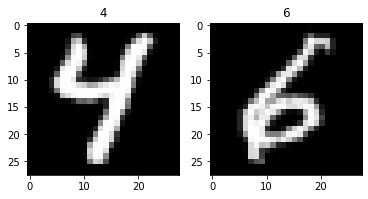

In [3]:
# show sample images with labels
# training data
plt.subplot(1,2,1)
plt.imshow(img_train[0], cmap='gray')
plt.title(lbl_train[0])

# test data
plt.subplot(1,2,2)
plt.imshow(img_test[-1], cmap='gray')
plt.title(lbl_test[-1]);

### Creating TensorFlow Datasets

TensorFlow datasets are used to feed the network (CNN), in our case we should import our Numpy arrays into datasets.

The standard tensor shape for feeding images to TensorFlow models has four dimensions (batch_size, heigh, width, no_channels). In grayscale images the pixels value defines its intensity in a range of 256 shades of gray from 0 (black) to 255 (white), the number channels dimension is not used since there is only one of them.

Images in RGB format use the red, green and blue channels to create color palettes, they require three channels. In this case the pixel value in each channel defines the filter intensity, also fom 0 to 255, and the combination of the three channels defines the color, so there are 16 milion possible colors for each pixel ($256^3 = 16.777.216$).

MNIST images are in grayscale without the channels dimension, we need to expand them with the fourth dimension to be complient with TensorFlow standard. After that we import images and labels into TensorFlow datasets setting them as a tupple (image, label), which defines the dataset elements.


In [4]:
# add 4th dimension to image arrays (TF standard)
img_train = np.expand_dims(img_train, axis=3)
img_test = np.expand_dims(img_test, axis=3)

# create TF Dataset from Numpy Arrays
data_train = tf.data.Dataset.from_tensor_slices((img_train, lbl_train),)
data_test = tf.data.Dataset.from_tensor_slices((img_test, lbl_test))

# print objects information
print('Training',
      '\n  Object type:', type(data_train),
      '\n  Image spec:', data_train.element_spec[0],
      '\n  Label spec:', data_train.element_spec[1])

print('\nTest',
      '\n  Object type:', type(data_test),
      '\n  Image spec:', data_test.element_spec[0],
      '\n  Label spec:', data_test.element_spec[1])

Training 
  Object type: <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> 
  Image spec: TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None) 
  Label spec: TensorSpec(shape=(), dtype=tf.uint8, name=None)

Test 
  Object type: <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> 
  Image spec: TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None) 
  Label spec: TensorSpec(shape=(), dtype=tf.uint8, name=None)


### Preparing Data

The data type was originally defined as integer *tf.uint8*, which comprehends the grayscale range between 0 and 255 ($2^8=256$).

The images will be casted to float *tf.float32*, this allows higher precision during the calculations. After that they will be rescaled to the range between 0.0 and 1.0, dividing the pixels values by 255.0, their maximum possible value, this helps to avoid overflow during weights calculations.

The labels will be casted to integer *tf.int32*, but there is no need for rescaling labels.

All of this is done by a user defined cast and rescale function, which receives image and label as parameters and returns the processed data. It is applied to the dataset using Python map() function, it calls our cast_rescale() function passing the dataset elements (image, label) as parameter.

In [5]:
def cast_rescale(image, label):
    '''Cast and rescale the input'''
    return tf.cast(image, tf.float32)/255., tf.cast(label, tf.int32)

# cast and rescale data
data_train = data_train.map(cast_rescale, num_parallel_calls=tf.data.AUTOTUNE)
data_test = data_test.map(cast_rescale, num_parallel_calls=tf.data.AUTOTUNE)

### Creating Data Iterators

One way to run model training sessions is using data batches, slices of the dataset fed to the network on an iterative way. After each batch processing the model parameters are updated using a gradient decent method.

Data iterators are set with the batch selection police, and they are handy because each time a batch is required they are provided accordingly without the need of manual selection. Data iterators can be created by user defined classes and/or functions, but TensorFlow already provides the tools we need to set them.

We will build our data iterators first caching the data into memory, then defining the shuffle method, in our case we set its buffer size to the number of entries in our dataset, doing this each training epoch makes use of the whole dataset. The buffer size can be set to half or a third of dataset size, then the dataset is used partially in each epoch, taking each half or third portion of it sequentially epoch after epoch.

We also set it to reshuffle at each iteration, meaning that for each epoch the batches are redefined again. It is also possible to set the shuffling seed for reproducibility.

The shuffling step is done only for training dataset, it is not required for tests.

Then we set the batch size, which is of relevant importance. As mentioned earlier, after each batch processing the model parameters are updated by a gradient decent method. The batch size also defines the number of entries used to calculate the gradient, it should be sufficient to generate a robust gradient and to allow the model convergence, but it should also be sufficient to allow the iterative process with enough number of batches, having more batches it is possible to update parameters more frequently.

Finally we define how TensorFlow should prefetch data, which is how many elements to prepare in advance to feed the network while it is processing the current one. It avoids waiting time to read and feed the data, but it requires more memory, when set to tf.data.AUTOTUNE it is dynamically adjusted.

For details about TensorFlow Datasets please check https://www.tensorflow.org/api_docs/python/tf/data/Dataset.

In [6]:
# define the batch size
batch_size = 64

# prepare training data for input
data_train = data_train.cache()
data_train = data_train.shuffle(buffer_size=len(data_train),
                                seed=1532,
                                reshuffle_each_iteration=True)
data_train = data_train.batch(batch_size)
data_train = data_train.prefetch(buffer_size=tf.data.AUTOTUNE)

# prepare test data for input
data_test = data_test.cache()
data_test = data_test.batch(batch_size)
data_test = data_test.prefetch(buffer_size=tf.data.AUTOTUNE)

# print objects information
print('Training',
      '\n  Object type:', type(data_train),
      '\n  Image spec:', data_train.element_spec[0],
      '\n  Label spec:', data_train.element_spec[1])

print('\nTest',
      '\n  Object type:', type(data_test),
      '\n  Image spec:', data_test.element_spec[0],
      '\n  Label spec:', data_test.element_spec[1])

Training 
  Object type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 
  Image spec: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None) 
  Label spec: TensorSpec(shape=(None,), dtype=tf.int32, name=None)

Test 
  Object type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 
  Image spec: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None) 
  Label spec: TensorSpec(shape=(None,), dtype=tf.int32, name=None)


### Understanding Convolution Operation

For the task of image classification we use convolutional neural networks (CNN), these networks are able to capture the correlation between the image pixels thus extract features to understand its content. It is performed by a convolution operation, performed by a sliding window, also called kernel, over the image. This operation outputs a new tensor with the image pixels cross-correlation, this output is called features map.

The operation starts from the top left position, first moving the kernel to the right, then to the bottom of the image. For each position the kernel passes it operates the calculation between its elements and the elements of the overlaped portion of the image.

It is not a formal way to describe it, but the example below helps to understand it. Suppose we have an input image $X$ with shape (3,3,1) and a convolutional kernel $K$ with shape (2,2,1):

$X = \begin{bmatrix} 0 & 1 & 2 \\ 3 & 4 & 5 \\ 6 & 7 & 8 \end{bmatrix},
K = \begin{bmatrix} 1 & 3 \\ 5 & 7 \end{bmatrix}$

First we position $K$ over the top left position of $X$ and perform the elementwise multiplication:

$\begin{bmatrix} 1 \times 0 & 3 \times 1 \\ 5 \times 3 & 7 \times 4 \end{bmatrix} = 
\begin{bmatrix} 0 & 3 \\ 15 & 28 \end{bmatrix}$

Next we sum up the elements: $0 + 3 + 15 + 28 = 46$

When sliding $K$ over $X$ from left to right and from top to bottom, the outputs are:

$1 \times 0 + 3 \times 1 + 5 \times 3 + 7 \times 4 = 46$

$1 \times 1 + 3 \times 2 + 5 \times 4 + 7 \times 5 = 62$

$1 \times 3 + 3 \times 4 + 5 \times 6 + 7 \times 7 = 94$

$1 \times 4 + 3 \times 5 + 5 \times 7 + 7 \times 8 = 110$

The features map, output of the convolution of $K$ over $X$, is then:

$O = \textrm{Conv}(X, K) = \begin{bmatrix} 46 & 62 \\ 94 & 110 \end{bmatrix}$

In our example the slide step had size equals to one, this means we moved one pixel each time, this is called stride. Strides can be set to higher values than one.

The features map has smaller dimensions compared to the input image, to avoid this effect we can expand the input with paddings. They are pixels with value zero added to the border of the original image.

### Convolution with Multi-channel Objects

The convolution kernel must always have the same number of channels as the image to be processed, the operation is performed per channel. Let's see an example with a two channels image $X$ with shape (3,3,2) and kernel $K$ (2,2,2).

$X = \left[{\begin{bmatrix} 0 & 1 & 2 \\ 3 & 4 & 5 \\ 6 & 7 & 8 \end{bmatrix}\;
\begin{bmatrix} 2 & 4 & 6 \\ 1 & 3 & 5 \\ 7 & 8 & 9 \end{bmatrix}}\right]$

$K = \left[{\begin{bmatrix} 1 & 3 \\ 5 & 7 \end{bmatrix}\;
\begin{bmatrix} 2 & 4 \\ 6 & 8 \end{bmatrix}}\right]$

For channel 1 we have: $O_1 = \textrm{Conv}(X_1,K_1) = \begin{bmatrix} 46 & 62 \\ 94 & 110 \end{bmatrix}$

For channel 2 we have: $O_2 = \textrm{Conv}(X_2,K_2)  = \begin{bmatrix} 50 & 90 \\ 113 & 146 \end{bmatrix}$

Next to find the features map, output of the convolution of $K$ over $X$, we sum up elementwise the channels operation outputs:

$O = O_1 + O_2 = \begin{bmatrix} 46+50 & 62+90 \\ 94+113 & 110+146 \end{bmatrix} = 
\begin{bmatrix} 96 & 152 \\ 207 & 256 \end{bmatrix}$

No matter how many channels the image contains, the convolution operation outputs a single features map.

Usually in convolutional neural networks several features maps are used to have different characteristics extracted from the input image, in this case the convolution operator should not contain a single kernel, but a group of kernels. 

When dealing with tensors, this can be done just including one dimension at its first position, instead of shape (heigh, width, no_channels), the kernel should have shape (no_filters, height, width, no_channels). In this case for each filter one convolution operation is performed providing one features map each.

To output three features maps in our example above we would have kernel $K$ with shape (3,2,2,2).

$K = \left[
\left[\begin{bmatrix} 1 & 3 \\ 5 & 7 \end{bmatrix}\; \begin{bmatrix} 2 & 4 \\ 6 & 8 \end{bmatrix}\right]\\
\left[\begin{bmatrix} 0 & 9 \\ 4 & 5 \end{bmatrix}\; \begin{bmatrix} 5 & 3 \\ 0 & 4 \end{bmatrix}\right]\\ 
\left[\begin{bmatrix} 2 & 3 \\ 6 & 5 \end{bmatrix}\; \begin{bmatrix} 1 & 7 \\ 9 & 6 \end{bmatrix}\right]
\right]$

### Pooling Operation

Pooling operation is used to aggregate information from the input at the same time to reduce its dimensionality, usually pooling layers are allocated after a convolutional layer.

There are two types of pooling layers, maximum pooling and average pooling. The operation is also done sliding a window, the pooling window, over the intput, but the operation is the extraction of the higher value, in case of max pooling, or the calculation of the average value, in case of average pooling.

Pooling windows do not hold any value, only their shape or size.

Suppose we have the same input $X$ with shape (3, 3) and a max pooling window $M$ with shape (2, 2).

$X = \begin{bmatrix} 0 & 1 & 2 \\ 3 & 4 & 5 \\ 6 & 7 & 8 \end{bmatrix},
M = \begin{bmatrix}  m_{11} & m_{12}  \\ m_{21}  & m_{22} \end{bmatrix}$

When $M$ is positioned over the top left position of $X$ it operates the function $\textrm{max}(0,1,3,4)=4$.

When sliding $M$ over $X$ from left to right and from top to bottom, the outputs are:

$\textrm{max}(0, 1, 3, 4)=4$

$\textrm{max}(1, 2, 4, 5)=5$

$\textrm{max}(3, 4, 6, 7)=7$

$\textrm{max}(4, 5, 7, 8)=8$

The output of the max pooling operation of $M$ over $X$ is then:

$O = \textrm{MaxPool}(X,M) = \begin{bmatrix}  4 & 5  \\ 7  & 8 \end{bmatrix}$

### Defining Model

We will build a TensorFlow Sequential model, which holds its layers in sequence and the output from a layer is passed as input to the next.

Our model will process the input image gradually increasing the number of feature maps (filters), using convolutional layers, and reducing the dimensionality, using pooling layers, from input shape (28,28,1) to (1,1,256). Convolutional neural networks extract images features on local perspective (pixel level) within intial layers, and on global perpective (image level) within the deep layers.

After extracting image features we reduce the number of feature maps to the same number of classes in our problem, they are 10, this is also achieved with a convolutional layer with output shape (1,1,10). Finally we use a flatten layer to reshape it to a tensor shape (1,10).

The output of the network contains the odds for the input image to belong to each of the ten classes, the class with the higher odds is considered as the best prediction for the input image.

We will also use batch normalization between convolutional and pooling layers, they normalize the output of the convolutional layers helping to avoid overfitting, they also allow the usage of more aggressive learning rates.

The main portion of the network has a standard layout:
1. Convolution
1. Batch normalization
1. Max pooling

To define the model we will have a function which receive as parameter a tupple with the layers configuration - number of output filters, convolution kernel size and pooling window size. It will add the layers in sequence according to the given tupple, then the flatten layer and return the model.

TensorFlow does not require to set the layer input shape, as it infers by himself, for convolutional layers only the output number of feature maps (filter) and the kernel size are required. Optionally strides and padding can be also set to manage the output dimensionality.

In [7]:
def model(layers_config):
    '''Defines a TensorFlow Sequential model'''
    model = keras.models.Sequential(name='DigitClassification')

    for i, (filters, kernel, pool) in enumerate(layers_config, start=1):
        # add convolutional layer
        model.add(layers.Conv2D(filters=filters, kernel_size=kernel,
                                strides=1, padding='same',
                                name='conv_'+str(i)))
        # add batch normalization layer
        model.add(layers.BatchNormalization(name='bnrm_'+str(i)))
        # add activation function layer
        model.add(layers.Activation('relu', name='actv_'+str(i)))
        
        if pool > 0:
            # add max pooling layer
            model.add(layers.MaxPool2D(pool_size=pool, strides=2,
                                       name='pool_'+str(i)))
    
    # add flatten layer
    model.add(layers.Flatten(name='flatten'))
    return model

There will be four convolutional layers for feature extraction, each of them followed by the batch normalization and activation. Then the classes odds calculation and the flatten layers.

1. Conv(3x3), 32 filters | Batch normalization | Activation | MaxPool(2x2)
1. Conv(3x3), 64 filters | Batch normalization | Activation | MaxPool(2x2)
1. Conv(3x3), 128 filters | Batch normalization | Activation | MaxPool(2x2)
1. Conv(3x3), 256 filters | Batch normalization | Activation | MaxPool(2x2)
1. Conv(1x1), 10 filters | Batch normalization | Activation
1. Flatten

Bellow we define the layers configuration, notice that the last position (10,1,0) is the odds calculation, the convolution kernel has size one and there is no pooling. 

Next we instantiate the model with defined layers configuration and build it with the expected input tensor shape. After that we use model summary to check its architecure and correct any mistake.

In [8]:
# define layers configuration ((no_filters, kernel_size, pool_size))
layers_config = ((32,3,2),(64,3,2),(128,3,2),(256,3,2),(10,1,0))

# instantiate and build model
cnn = model(layers_config)
cnn.build(input_shape=(1,28,28,1))

# check model architecture
cnn.summary()

Model: "DigitClassification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (1, 28, 28, 32)           320       
                                                                 
 bnrm_1 (BatchNormalization)  (1, 28, 28, 32)          128       
                                                                 
 actv_1 (Activation)         (1, 28, 28, 32)           0         
                                                                 
 pool_1 (MaxPooling2D)       (1, 14, 14, 32)           0         
                                                                 
 conv_2 (Conv2D)             (1, 14, 14, 64)           18496     
                                                                 
 bnrm_2 (BatchNormalization)  (1, 14, 14, 64)          256       
                                                                 
 actv_2 (Activation)         (1, 14, 14, 64)   

### Model Callbacks

Almost there!

Before we start training the model, we will define three TensorFlow Callbacks, they are used to control the learning process and to record information about the model.

1. Reduce Learning Rate on Plateau: it reduces the learning rate to enhance the model parameters update. It will monitor the validation loss, when it does not improve at a minimum delta the factor will be applied to the learning rate.
1. Model Checkpoint: it saves the model for future usage, like during predictions. It will save the best version of the model, also monitoring the validation loss.
1. CSV Logger: creates the model log in a CSV file, it can be used to get knowledge about the learning dynamics allowing improvements.

There are much more callback otions, for details about TensorFlow Callbacks please check https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback.

In [9]:
# define folder and files to store model check point and log
folder = '/content/drive/MyDrive/Colab Notebooks/Handwriting/'
ckpfile = folder+'DigitClassification_ckp'
logfile = folder+'DigitClassification_log.csv'

# define reduce learning rate callback
Reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                              patience=2, verbose=0,
                                              mode='auto', min_delta=5e-4,
                                              cooldown=0, min_lr=(1e-5))

# define model checkpoint callback
Checkpoint = keras.callbacks.ModelCheckpoint(filepath=ckpfile,
                                             monitor='val_loss', verbose=0,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto')

# define model logger callback
Logger = keras.callbacks.CSVLogger(filename=logfile, separator=',',
                                   append=False)

### Training Model

We will set the learning rate to 0.02 and the number of epochs to 20. For compiling we will use SGD optimizer, cross-entropy loss, since it is a classification problem, and sparse categorical accuracy as metric, it calculates how often predictions match integer labels.

Actually it is normal to try several different setups during the training, I spent some time tuning it to achive the results below.

In [10]:
# define learning rate and number of epochs
learn_rate = 0.02
num_epochs = 20

# compile model
cnn.compile(optimizer = keras.optimizers.SGD(learn_rate),
            loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics = [keras.metrics.SparseCategoricalAccuracy()])

# train model
cnn.fit(data_train, epochs=num_epochs, validation_data=data_test,
        callbacks=[Reduce_LR, Checkpoint, Logger])

Epoch 1/20
938/938 [==============================] - 12s 8ms/step - loss: 0.3073 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.1229 - val_sparse_categorical_accuracy: 0.9864 - lr: 0.0200
Epoch 2/20
938/938 [==============================] - 7s 8ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.0786 - val_sparse_categorical_accuracy: 0.9909 - lr: 0.0200
Epoch 3/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0719 - sparse_categorical_accuracy: 0.9911 - val_loss: 0.0515 - val_sparse_categorical_accuracy: 0.9924 - lr: 0.0200
Epoch 4/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.9932 - val_loss: 0.0424 - val_sparse_categorical_accuracy: 0.9922 - lr: 0.0200
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0426 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0396 - val_sparse_categorical_accuracy: 0.9914 - lr: 0.0200
Epoch 6/20
938/938 [==============

We can see from the console output the callbacks working, the learning rate reduction was triggered when no improvement was made in validation loss after two epochs, and that the model was saved only when there was validation loss improvement.

### Analysing Log

We will use the log file just recorded to have a better understanding of the training dynamics.

First let's check what it contains, the columns are in the same position as the console output TensorFlow provided above.

1. Epoch
1. Training loss
1. Training accuracy
1. Validation loss
1. Validation accuracy
1. Learning rate

In [11]:
# load the model log
model_log = np.loadtxt(logfile, dtype=np.float32, delimiter=',', skiprows=1)
model_log

array([[0.000e+00, 3.073e-01, 2.000e-02, 9.704e-01, 1.229e-01, 9.864e-01],
       [1.000e+00, 1.092e-01, 2.000e-02, 9.881e-01, 7.860e-02, 9.909e-01],
       [2.000e+00, 7.194e-02, 2.000e-02, 9.911e-01, 5.154e-02, 9.924e-01],
       [3.000e+00, 5.372e-02, 2.000e-02, 9.932e-01, 4.236e-02, 9.922e-01],
       [4.000e+00, 4.261e-02, 2.000e-02, 9.949e-01, 3.964e-02, 9.914e-01],
       [5.000e+00, 3.549e-02, 2.000e-02, 9.955e-01, 4.117e-02, 9.910e-01],
       [6.000e+00, 2.923e-02, 2.000e-02, 9.971e-01, 3.010e-02, 9.944e-01],
       [7.000e+00, 2.606e-02, 2.000e-02, 9.971e-01, 2.597e-02, 9.939e-01],
       [8.000e+00, 2.310e-02, 2.000e-02, 9.977e-01, 2.378e-02, 9.940e-01],
       [9.000e+00, 2.110e-02, 2.000e-02, 9.978e-01, 2.578e-02, 9.942e-01],
       [1.000e+01, 1.818e-02, 2.000e-02, 9.984e-01, 2.389e-02, 9.943e-01],
       [1.100e+01, 1.535e-02, 1.000e-02, 9.989e-01, 2.062e-02, 9.948e-01],
       [1.200e+01, 1.409e-02, 1.000e-02, 9.990e-01, 2.022e-02, 9.946e-01],
       [1.300e+01, 1.384e

Now we use the log data to plot the results, the first plot shows the improvement of accuracy, and the gap between training and validation. The second plot shows the improvements in validation loss, which was our target during monitoring.

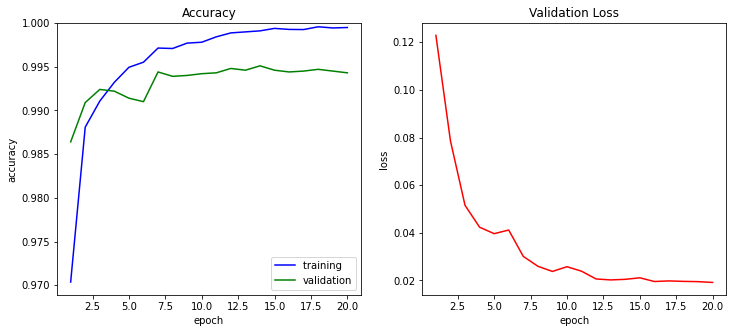

In [12]:
# define figure
fig = plt.figure(figsize=(12,5))

# plot training and validation accuracy
ax = fig.add_subplot(1,2,1)
ax.plot(model_log[:,0]+1, model_log[:,3], color='b', label='training ')
ax.plot(model_log[:,0]+1, model_log[:,5], color='g', label='validation')
ax.set_title('Accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_ylim(bottom=None, top=1)
ax.legend(loc='lower right')

# plot validation loss
ax = fig.add_subplot(1,2,2)
plt.plot(model_log[:,0]+1, model_log[:,4], color='r', label='validation')
ax.set_title('Validation Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_ylim(bottom=None, top=None)

# show figure
plt.show();

Both plots show that huge improvement was make until epoch 12, then it was still improving, but at a slower pace, completely normal behaviour. The accuracy plot also shows the gap between training and validation, anyway validation achieved pretty high accuracy of 99.43%, what is probably higher than a human reading handwritten digits.

It could still be improved if we had some more epochs, or even better a more robust model, but in this case the cost of processing could not worth it.

To finish it, below we select the best epoch to check its details.

In [13]:
# select the epoch with minimum validation loss
best_epoch = model_log[model_log[:,4]==model_log[:,4].min()].reshape(6,)

# print best epoch details
print('Best Epoch\t', int(best_epoch[0]+1), '/', num_epochs,
      '\nTrain. Accuracy\t',round(best_epoch[3],4),
      '\nValid. Accuracy\t',round(best_epoch[5],4),
      '\nValid. Loss\t',round(best_epoch[4],4),)

Best Epoch	 20 / 20 
Train. Accuracy	 0.9995 
Valid. Accuracy	 0.9943 
Valid. Loss	 0.0192
